#### Create our first numerai model - will use ensemble of randomforest regressor, support vector regression and conditional inference. Will also use a cross-validation approach along with random search for hyperparameter tuning

In [ ]:
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
#from rgf.sklearn import RGFRegressor
#from catboost import CatBoostRegressor

In [1]:
import sys

import numerapi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA

In [2]:
public_key='Z3WSDWZNFSLTNXIJPUGWLXUEXNRGENV6'
secret_key='LNA57ECIKXLOO73P2JS3CA56BNMAA6BFVFY2YTAQ7IEBS47HWVDFYM7PRHT5OSD2'
model_id='cf1b66bc-0e73-44dd-95b4-e3021ea3b09a'

In [12]:
try:
    train_data=pd.read_csv('../data/numerai_dataset_252/numerai_training_data.csv').set_index('id')
    test_data=pd.read_csv('../data/numerai_dataset_252/numerai_tournament_data.csv').set_index('id')
except Exception as e:
    num_api = numerapi.NumerAPI(public_key, secret_key,verbosity="info")
    num_api.download_current_dataset(dest_path='../data/')

In [5]:
train_data.head()

,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
id,,,,,,,,,,,,,,,,,,,,,
n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [5]:
feature_names=[c for c in train_data.columns if 'feature' in c]

#### Scoring functions 

In [7]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return numpy.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return numpy.corrcoef(y_true, y_pred)[0,1]

#### Preprocessing

Lets look at correlations on the features

In [28]:
correlations=train_data[feature_names].corr()

In [51]:
corr_stack = correlations.stack()
corr_stack = corr_stack[corr_stack.index.get_level_values(0)<corr_stack.index.get_level_values(1)]
corr_stack.sort_values()

feature_constitution112  feature_constitution9    -0.855008
feature_constitution33   feature_constitution46   -0.830310
feature_constitution112  feature_constitution60   -0.820694
feature_constitution46   feature_constitution87   -0.815888
feature_constitution112  feature_constitution33   -0.759084
                                                     ...   
feature_constitution27   feature_constitution7     0.948920
feature_constitution13   feature_constitution79    0.949139
feature_wisdom31         feature_wisdom39          0.954984
feature_wisdom46         feature_wisdom7           0.963706
feature_wisdom12         feature_wisdom2           0.968062
Length: 47895, dtype: float64

In [7]:
NUM_COMPONENTS=50

In [11]:
train_data=np.nan_to_num(train_data[feature_names])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
train_data

In [8]:
print('Number of features: {}'.format(len(feature_names)))
pca=PCA(n_components=NUM_COMPONENTS)
pca.fit(train_data[feature_names])

Number of features: 310


PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

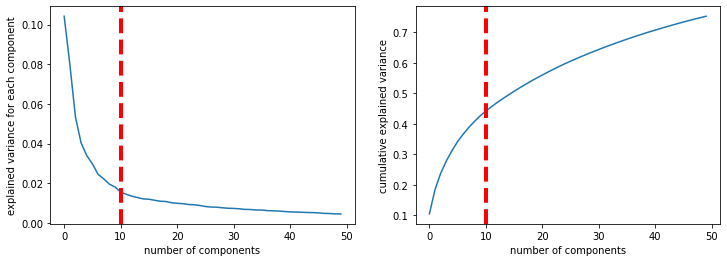

In [14]:
f, axes=plt.subplots(1,2,figsize=(12,4))
axes[0].plot(pca.explained_variance_ratio_)
axes[0].set_xlabel('number of components')
axes[0].set_ylabel('explained variance for each component')
axes[0].axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)

axes[1].plot(np.cumsum(pca.explained_variance_ratio_))
axes[1].set_xlabel('number of components')
axes[1].set_ylabel('cumulative explained variance')
axes[1].axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)

In [15]:
x_train_pca = pca.transform(train_data[feature_names])
x_test_pca = pca.transform(test_data[feature_names])

In [17]:
x_train_pca[:5].shape

(5, 50)

In [60]:
x_train_pca_df=pd.DataFrame(x_train_pca)
correlations_pca=x_train_pca_df.corr()
stack_corr_pca=correlations_pca.stack()
stack_corr_pca=stack_corr_pca[stack_corr_pca.index.get_level_values(0)<stack_corr_pca.index.get_level_values(1)]

0   1    -1.792831e-13
    2     3.641926e-13
    3    -9.711140e-12
    4     1.285948e-11
    5     7.381696e-12
              ...     
46  48   -3.311675e-03
    49   -1.690684e-03
47  48    4.583795e-04
    49    1.208245e-03
48  49    3.099369e-03
Length: 1225, dtype: float64

In [61]:
stack_corr_pca.head()

0  1   -1.792831e-13
   2    3.641926e-13
   3   -9.711140e-12
   4    1.285948e-11
   5    7.381696e-12
dtype: float64

#### Random Forest

Lets consider a number of parameters to tune
- number of forests
- max features to split on each node
- max depth of the tree
- boostrap
- min samples split: minimum number of data points before node is split
- min sample leaf: minimum number of data points allowed in a leaf node

In [12]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [13]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestRegressor()
rf_randomsearch=RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                                   cv=10, n_iter=100, n_jobs=-1)

model_rf=rf_randomsearch.fit(x_train_pca,train_data['target'])

In [ ]:
print('best model: {}'.format(model_rf.best_estimator_))
print('best score: {}'.format(model_rf.best_score_))
print('best model_params: {}'.format(model_rf.best_params_))

In [70]:
params_results = pd.DataFrame(model_rf.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
params_results = params_results.drop(['mean_fit_time', 'std_fit_time','mean_score_time',
                                     'std_score_time','params','split0_test_score',
                                     'split1_test_score', 'std_test_score'], axis=1)

In [72]:
params_results.head(5)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,20,5,4,sqrt,40,True,-0.889750,1
1,20,2,2,auto,70,True,-1.072444,2
2,161,5,4,auto,40,True,-1.210183,3
3,161,2,2,sqrt,30,True,-1.238642,4
4,444,5,1,sqrt,70,True,-1.250355,5


NameError: name 'params_results' is not defined

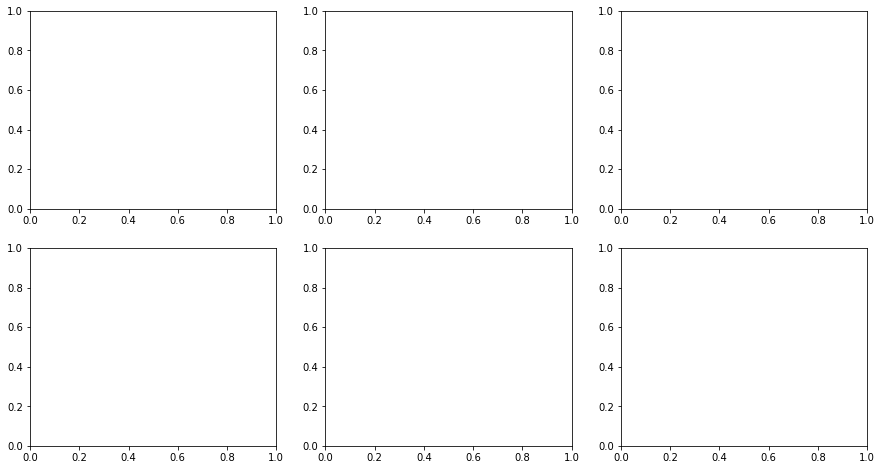

In [19]:
f,axes=plt.subplots(2,3,figsize=(15,8))
sns.barplot(x='param_n_estimators',y='mean_test_score',data=params_results,color='blue',ax=axes[0,0])
sns.barplot(x='param_min_samples_leaf',y='mean_test_score',data=params_results,color='blue',ax=axes[0,1])
sns.barplot(x='param_max_features',y='mean_test_score',data=params_results,color='blue',ax=axes[0,2])
sns.barplot(x='param_max_depth',y='mean_test_score',data=params_results,color='blue',ax=axes[1,0])
sns.barplot(x='param_bootstrap',y='mean_test_score',data=params_results,color='red',ax=axes[1,1])
sns.barplot(x='param_min_samples_split',y='mean_test_score',data=params_results,color='blue',ax=axes[1,2])

plt.tight_layout()

In [ ]:
rf_model_best=model_rf.best_estimator_
rf_model_best.fit(train_data[feature_names],train_data['target'])
predictions=rf_model_best.predict(test_data[feature_names])

#### gradient boosting

In [ ]:
loss=['ls', 'lad', 'huber', 'quantile']
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
learning_rate = [0.1,0.01,0.001]

random_grid = {'loss': loss,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate':learning_rate}

In [ ]:
gb = GradientBoostingRegressor()
gb_randomsearch=RandomizedSearchCV(estimator=gb, param_distributions=random_grid, n_iter=100)
gb_model=gb_randomsearch.fit(train_data[feature_names],train_data['target'])

In [ ]:
print('best model: {}'.format(model_rf.best_estimator_))
print('best score: {}'.format(model_rf.best_score_))
print('best model_params: {}'.format(model_rf.best_params_))

In [ ]:
gb_model_best=model_rf.best_estimator_
#gb_model_best.fit(train_data[feature_names][:5],train_data['target'][:5])
#predictions=gb_model_best.predict(test_data[feature_names])

In [7]:
criterion=['mse', 'mae']
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 15)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [8]:
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
xtrees = ExtraTreesRegressor()
x_randomsearch=RandomizedSearchCV(estimator=xtrees,param_distributions=random_grid,n_iter=100)
x_model=x_randomsearch.fit(train_data[feature_names],train_data['target'])

#### support vector machines

In [ ]:
kernel=['linear', 'poly', 'rbf', 'sigmoid']
degree=[2,3,4,5]
gamma=['scale', 'auto']
C=[1,2,3,4,5]
epsilon=[0.1,0.2,0.3,0.4,0.5]
shrinking=[True,False]

In [ ]:
random_grid={
             'kernel':kernel,
             'degree':degree,
             'gamma':gamma,
             'C': C,
             'epsilon':epsilon,
             'shrinking':shrinking
            }

In [ ]:
svr = SVR()
svr_randomsearch=RandomizedSearchCV(estimator=svr,param_distributions=random_grid,n_iter=100)
model_svr=svr_randomsearch.fit(train_data[feature_names],train_data['target'])

In [ ]:
print('best model: {}'.format(model_svr.best_estimator_))
print('best score: {}'.format(model_svr.best_score_))
print('best model_params: {}'.format(model_svr.best_params_))

svr_model_best=model_svr.best_estimator_
#svr_model_best.fit(train_data[feature_names][:5],train_data['target'][:5])
#predictions=svr_model_best.predict(test_data[feature_names])

In [ ]:
ensemble = VotingRegressor(estimators=[('rf', rf_model_best), ('gb', gb_model_best), ('svr', svr_model_best)])
ensemble = ensemble.fit(train_data[feature_names], train_data['target'])
predictions=ensemble.predict(test_data[feature_names])

#### xgboost regressor

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 15)]
learning_rate=[0.0001, 0.001, 0.1]
min_child_weight=[0.1, 1, 5, 10, 50]
gamma=[0.5, 1, 1.5, 2, 5]
subsample=[0.6, 0.8, 1.0]
colsample_bytree=[0.6, 0.8, 1.0]
max_depth=[5, 10, 25, 50]
learning_rate=[0.0001, 0.001, 0.1]
n_estimators=[50, 100, 250, 500]
reg_alpha=[0.0001, 0.001, 0.1, 1]
reg_lambda=[0.0001, 0.001, 0.1, 1]

random_grid = {
    'min_child_weight':[0.1, 1, 5, 10, 50],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 25, 50],
    'learning_rate': [0.0001, 0.001, 0.1],
    'n_estimators': [50, 100, 250, 500],
    'reg_alpha': [0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0.0001, 0.001, 0.1, 1]
    }

In [ ]:
xgb = XGBRegressor()
xgb_randomsearch=RandomizedSearchCV(estimator=xgb,param_distributions=random_grid,n_iter=100)
xgb_model=xgb_randomsearch.fit(train_data[feature_names],train_data['target'])

In [ ]:
print('best model: {}'.format(model_rf.best_estimator_))
print('best score: {}'.format(model_rf.best_score_)
print('best model_params: {}'.format(model_rf.best_params_)

In [ ]:
xgb_model_best=model_rf.best_estimator_
xgb_model_best.fit(train_data[feature_names][:5],train_data['target'][:5])
predictions=xgb_model_best.predict(test_data[feature_names])

#### lgbm regressor

In [ ]:
lgbm = LGBMBoostRegressor()

#### catboost regressor

In [ ]:
cb_model = CatBoostRegressor()